## Project 1-Copy

#### Summer 2021
**Authors:** GOAT Team (Estaban Aramayo, Ethan Haley, Claire Meyer, and Tyler Frankenburg)

The [Cocktail DB](https://www.thecocktaildb.com/api.php) is a database of cocktails and ingredients. In this assignment, we describe how we could use the Cocktail DB's API to generate a network of cocktails and ingredients. We can use some example data to explore how we might be able to predict outcomes from this data using centrality metrics. 

### Loading the Data

Without digging too deeply into the intricacies of the Cocktail DB API, we can leverage [this code](https://holypython.com/api-12-cocktail-database/) as a start for grabbing some example output from the API. This code leverages 2 libraries: `requests` to make an API request, and `json` to load the JSON output from the API. We can then iterate through each cocktail output to grab the relevant components. 

We can bulid a search query to pull all cocktail names (`strDrink`), the ingredients for each, and the drink categories (`strCategory`) for each cocktail.

First, we get all drinks, by first letter of name.

In [2]:
import networkx as net
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
import numpy as np

In [3]:
baseUrl = "https://www.thecocktaildb.com/api/json/v1/1/"
letterEndpoint = "search.php?f="

def searchLetter(letter):
    data = requests.get(baseUrl + letterEndpoint + letter)
    return json.loads(data.text)

In [4]:
# Build a dataframe
name = []  # drink name
ids = []   # drink ID
cat = []   # drink category
pic = []   # thumbnail url
ingr = []  # ingredients

In [5]:
# Helper function to parse ingredients
def ingreds(drinkDict):
    ing = []
    for i in range(1,16):  # API has 16 fields for ingredients of each drink, most of them empty/None
        s = "strIngredient" + str(i)
        if not d[s]:
            break
        ing.append(d[s])
    return ing

In [6]:
for l in 'abcdefghijklmnopqrstuvwxyz':
    
    drinks = searchLetter(l)['drinks']
    if not drinks: continue   #(some letters have no drinks)
    for d in drinks:
        # Make drinks upper case to distinguish from lower case ingredients of same name
        name.append(str.upper(d['strDrink']))
        ids.append(d['idDrink'])
        cat.append(d['strCategory'])
        pic.append(d['strDrinkThumb'])
        ingr.append([str.lower(i) for i in ingreds(d)])

In [7]:
drinkDF = pd.DataFrame({'name': name,
                       'id': ids,
                       'category': cat,
                       'photoURL': pic,
                       'ingredients': ingr})
drinkDF.head()

,name,id,category,photoURL,ingredients
0,A1,17222,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[gin, grand marnier, lemon juice, grenadine]"
1,ABC,13501,Shot,https://www.thecocktaildb.com/images/media/dri...,"[amaretto, baileys irish cream, cognac]"
2,ACE,17225,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[gin, grenadine, heavy cream, milk, egg white]"
3,ADAM,17837,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[dark rum, lemon juice, grenadine]"
4,AT&T,13938,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[absolut vodka, gin, tonic water]"


### Bipartite Projections

Then, we can make a bipartite graph, with cocktails as one type and ingredients as the other.

First we can play with a high-level graph of the full dataset, creating a bipartite graph where drinks are one type and ingredients are the other.

In [8]:
from networkx.algorithms import bipartite

name = drinkDF.name.values
cat = drinkDF.category.values
ingr = drinkDF.ingredients.values

drinks = set(name)
ingreds = set(i for iList in ingr for i in iList)

B = net.Graph()
B.add_nodes_from(drinks, bipartite='Drink')
B.add_nodes_from(ingreds, bipartite='Ingredient')

for d in range(len(drinkDF)):
    B.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        B.add_edge(name[d], ing)

Then the 2 bipartite projection graphs are these:

In [9]:
D = bipartite.weighted_projected_graph(B, drinks)
I = bipartite.weighted_projected_graph(B, ingreds)

### Break it down by Category

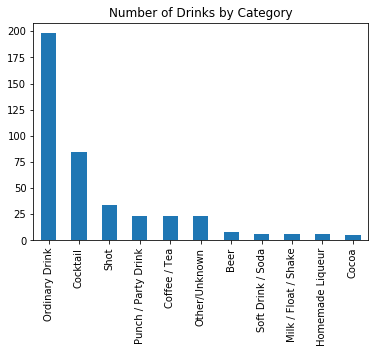

In [10]:
drinkDF.category.value_counts().plot(kind='bar')
plt.title('Number of Drinks by Category');

Ultimately, we want to compare centrality measures across our drink categories of interest: 'Cocktail','Ordinary Drink', and 'Shot'. We can create sub-dataframes of 3 key categories: 'cocktail', 'shot', and 'ordinary drink', that we can then compare key centrality measures across.

In [11]:
drinks_cocktails = drinkDF[(drinkDF['category']=="Cocktail")]
drinks_ordinary = drinkDF[(drinkDF['category']=="Ordinary Drink")]
drinks_shots = drinkDF[(drinkDF['category']=="Shot")]

First, let's look at our Drinks graph, colored by category: 

In [12]:
colors = []
for node in D:
    if node in drinks_cocktails.name.values:
        colors.append("lightblue")
    elif node in drinks_shots.name.values:
        colors.append("plum")
    elif node in drinks_ordinary.name.values:
        colors.append("gold")
    else: colors.append("lightgreen")
        
#node colors adapted from source: https://stackoverflow.com/a/59473049

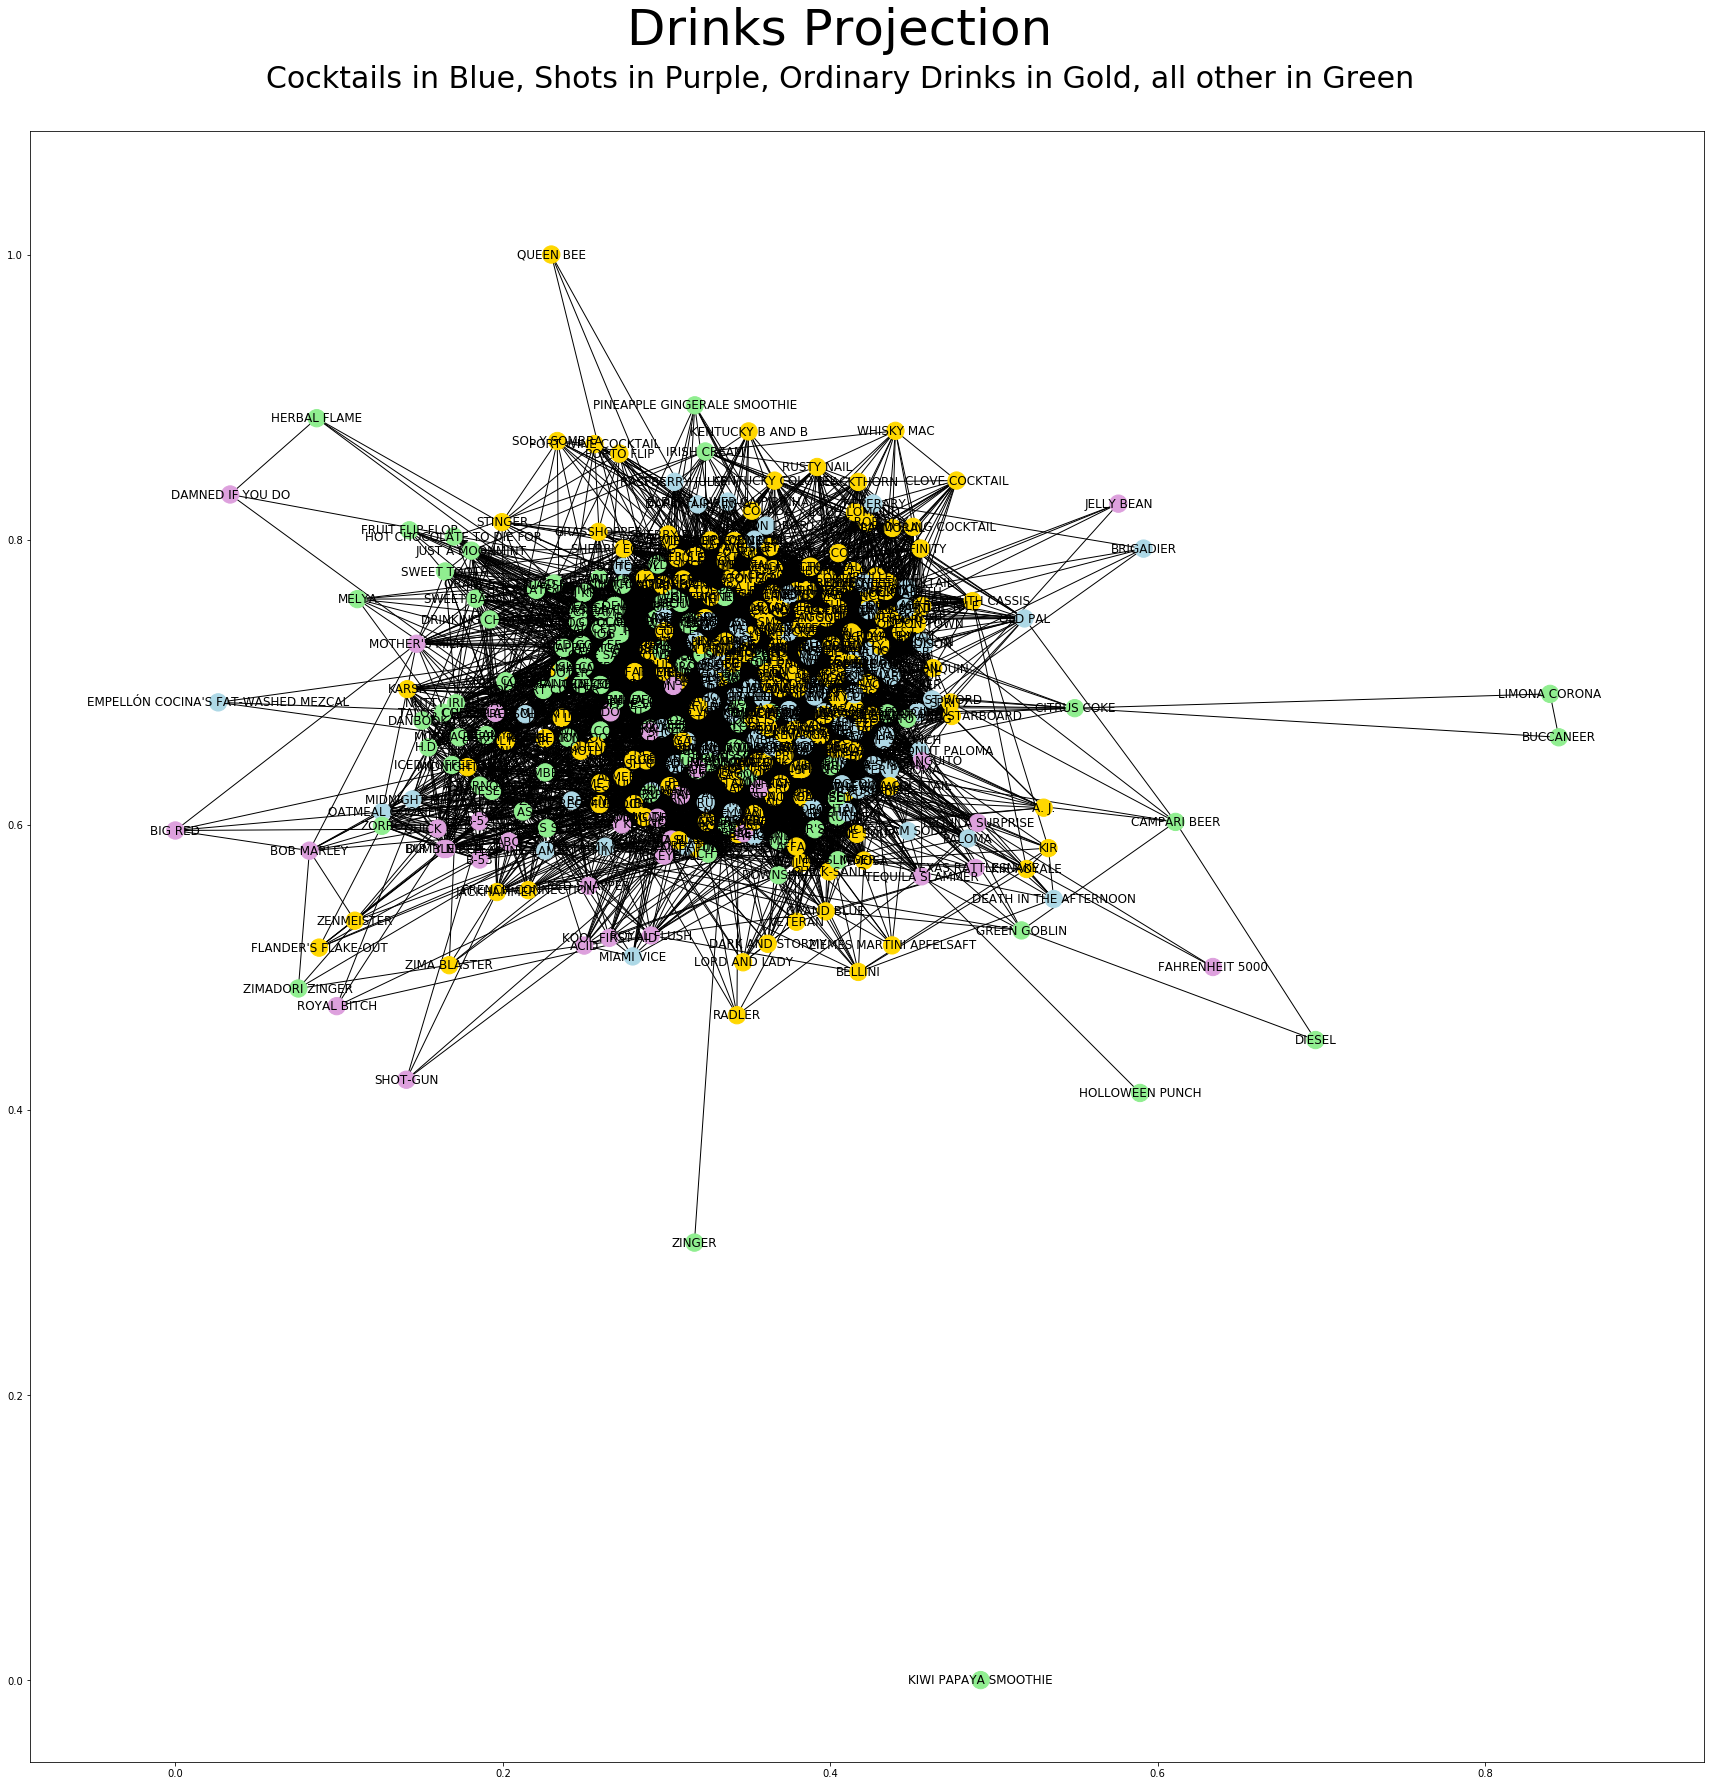

In [13]:
plt.figure(figsize = (30, 30))
ax = plt.subplot()

net.draw_networkx(D, ax=ax, node_color = colors)

plt.figtext(.5,.92,'Drinks Projection', fontsize=50, ha='center')
plt.figtext(.5,.9, 'Cocktails in Blue, Shots in Purple, Ordinary Drinks in Gold, all other in Green', fontsize = 30, ha='center')
plt.show()

In [15]:
net.write_graphml(B, "all_nodes.graphml")
net.write_graphml(D, "drinks_projection.graphml")
net.write_graphml(I, "ingreds_projection.graphml")

This is a bit challenging to interpret, but we do see what looks like a close cluster of Ordinary Drinks. 

From the subsetted dataframes, we can create bipartite drink and ingredient graphs for each category, to prepare to compare centrality measures.

In [69]:
drinks_c = set(drinks_cocktails.name.values)
ingreds_c = set(i for iList in drinks_cocktails.ingredients.values for i in iList)

dc_graph = net.Graph()

dc_graph.add_nodes_from(drinks_c, bipartite='Drink')
dc_graph.add_nodes_from(ingreds_c,bipartite='Ingredient')

for d in drinks_cocktails.index:
    dc_graph.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        dc_graph.add_edge(name[d], ing)

Then we create a dataframe of degree and eigenvector centrality by each drink.

In [70]:
cocktail_degree = net.degree_centrality(dc_graph)
cocktail_degree = pd.DataFrame.from_dict(cocktail_degree, orient='index').reset_index()

In [71]:
cocktail_eig = net.eigenvector_centrality_numpy(dc_graph)
cocktail_eig = pd.DataFrame.from_dict(cocktail_eig, orient='index').reset_index()

We repeat these steps across the two other categories: 

In [72]:
drinks_o = set(drinks_ordinary.name.values)
ingreds_o = set(i for iList in drinks_ordinary.ingredients.values for i in iList)

do_graph = net.Graph()

do_graph.add_nodes_from(drinks_o, bipartite='Drink')
do_graph.add_nodes_from(ingreds_o,bipartite='Ingredient')

for d in drinks_ordinary.index:
    dc_graph.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        do_graph.add_edge(name[d], ing)

In [73]:
ordinary_degree = net.degree_centrality(do_graph)
ordinary_degree = pd.DataFrame.from_dict(ordinary_degree, orient='index').reset_index()

In [74]:
ordinary_eig = net.eigenvector_centrality_numpy(do_graph)
ordinary_eig = pd.DataFrame.from_dict(ordinary_eig, orient='index').reset_index()

In [75]:
drinks_s = set(drinks_shots.name.values)
ingreds_s = set(i for iList in drinks_shots.ingredients.values for i in iList)

ds_graph = net.Graph()

ds_graph.add_nodes_from(drinks_s, bipartite='Drink')
ds_graph.add_nodes_from(ingreds_s,bipartite='Ingredient')

for d in drinks_shots.index:
    ds_graph.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        ds_graph.add_edge(name[d], ing)

In [76]:
shots_degree = net.degree_centrality(ds_graph)
shots_degree = pd.DataFrame.from_dict(shots_degree, orient='index').reset_index()

In [77]:
shots_eig = net.eigenvector_centrality_numpy(ds_graph)
shots_eig = pd.DataFrame.from_dict(shots_eig, orient='index').reset_index()

### Compare Centrality Measures across Categories
Now we're ready to compare the centrality values across our categories. We'll do this by: 
1. Create summary dataframe of both centrality measures for all categories.
2. Recombine category-level dataframes into one summary frame. 
3. Look at mean values by category. 
4. Check ANOVA assumptions + conduct ANOVA analysis. 


##### 1 and 2: Prepping Summary Dataframe

In [78]:
summary_cocktails = pd.merge(cocktail_degree, cocktail_eig, how = "inner", on = "index")
summary_cocktails = summary_cocktails.rename(columns = 
        {"index":"Name","0_x":"degree","0_y":"eigenvector"})
summary_cocktails['category'] = 'Cocktail'
summary_cocktails.head()

,Name,degree,eigenvector,category
0,MUNICH MULE,0.022026,0.138348,Cocktail
1,WINTER PALOMA,0.022026,0.055935,Cocktail
2,THE PHILOSOPHER,0.022026,0.127643,Cocktail
3,A1,0.017621,0.144103,Cocktail
4,OLD FASHIONED,0.017621,0.041111,Cocktail


In [79]:
summary_ordinary = pd.merge(ordinary_degree, ordinary_eig, how = "inner", on = "index")
summary_ordinary = summary_ordinary.rename(columns = 
        {"index":"Name","0_x":"degree","0_y":"eigenvector"})
summary_ordinary['category'] = 'Ordinary'
summary_ordinary.head()

,Name,degree,eigenvector,category
0,ALEXANDER,0.011396,0.063138,Ordinary
1,PORTO FLIP,0.008547,0.006327,Ordinary
2,TEQUILA SOUR,0.011396,0.049719,Ordinary
3,RUM TODDY,0.011396,0.037710,Ordinary
4,AUTODAFÉ,0.008547,0.015216,Ordinary


In [80]:
summary_shots = pd.merge(shots_degree, shots_eig, how = "inner", on = "index")
summary_shots = summary_shots.rename(columns = 
        {"index":"Name","0_x":"degree","0_y":"eigenvector"})
summary_shots['category'] = 'Shots'
summary_shots.head()

,Name,degree,eigenvector,category
0,JELLY BEAN,0.022989,-2.608097e-17,Shots
1,MORANGUITO,0.034483,8.951325e-17,Shots
2,SHOT-GUN,0.034483,1.319260e-02,Shots
3,ORANGE CRUSH,0.034483,1.671549e-01,Shots
4,ROYAL BITCH,0.022989,2.177808e-02,Shots


In [81]:
summary_all = summary_cocktails
summary_all = summary_all.append([summary_shots,summary_ordinary])
summary_all.head()

,Name,degree,eigenvector,category
0,MUNICH MULE,0.022026,0.138348,Cocktail
1,WINTER PALOMA,0.022026,0.055935,Cocktail
2,THE PHILOSOPHER,0.022026,0.127643,Cocktail
3,A1,0.017621,0.144103,Cocktail
4,OLD FASHIONED,0.017621,0.041111,Cocktail


##### 3: Comparing Mean and Median Values

Then we can use our summary table to compare mean and median values. We see 'Shots' has higher Degree and Eigenvector centrality in terms of both Mean and Median.

In [82]:
grouped_summary = summary_all.groupby("category")
mean_grouped = grouped_summary.mean()
mean_grouped

,degree,eigenvector
category,,
Cocktail,0.013564,0.039303
Ordinary,0.012205,0.031799
Shots,0.026907,0.069453


In [83]:
median_grouped = grouped_summary.median()
median_grouped

,degree,eigenvector
category,,
Cocktail,0.011013,0.020035
Ordinary,0.008547,0.016938
Shots,0.022989,0.040718


##### 4: Check ANOVA Assumptions and Conduct ANOVA Test

ANOVA tests are useful to compare mean values across multiple categories, versus a 2-sample test for example. This analysis will tell us if our means are materially diffferent by group. 

The code below is repurposed from a tutorial [here](https://towardsdatascience.com/anova-test-with-python-cfbf4013328b). 

Before we start the analysis, we should check our ANOVA assumptions, namely: 
- Independence, which we can assume to be true.
- Normally distributed values within each group
- Equal variances between all groups

To start, we compare a box plot across the categories. These plots suggest there are differences between categories, but also extensive outliers in both the Cocktail and Ordinary Drink categories. These will complicate the other assumptions, as we'll see, but we can still run the ANOVA in a demonstration capacity.

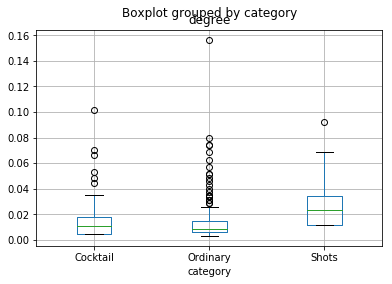

In [84]:
summary_all.boxplot('degree',by='category')

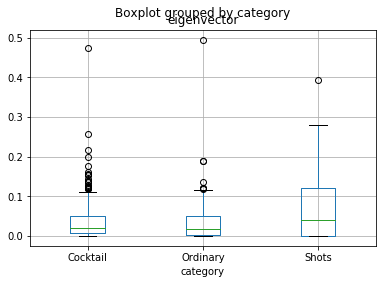

In [85]:
summary_all.boxplot('eigenvector',by='category')

First, we check for normality in both centrality metrics. We find that, particularly for Degree centrality, there is not a normal distribution. 

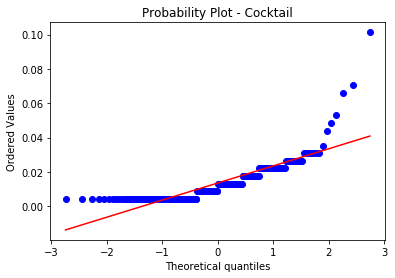

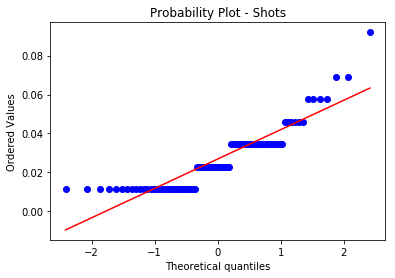

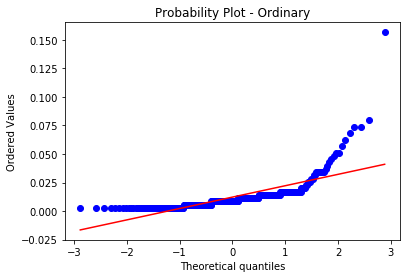

In [86]:
unique_cat = summary_all['category'].unique()
for category in unique_cat:
    stats.probplot(summary_all[summary_all['category'] == category]['degree'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  category)
    plt.show()

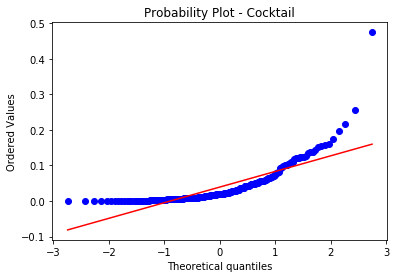

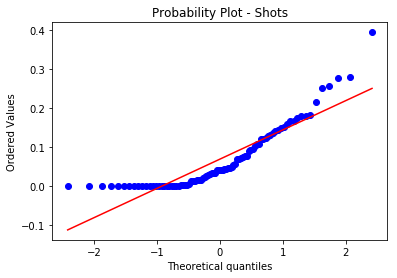

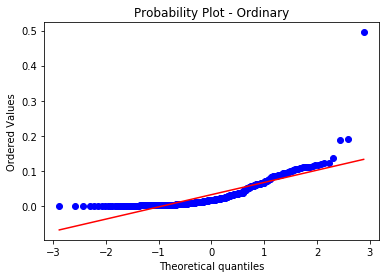

In [87]:
unique_cat = summary_all['category'].unique()
for category in unique_cat:
    stats.probplot(summary_all[summary_all['category'] == category]['eigenvector'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  category)
    plt.show()

Then we check for the ratio of the largest and smallest standard deviation, looking for values below '2'. 

In [88]:
ratio = summary_all.groupby('category').std().max() / summary_all.groupby('category').std().min()
ratio

degree         1.377568
eigenvector    1.898718
dtype: float64

Despite assumptions not holding, we can move forward with the analysis and exercise caution with the results. The code below follows the tutorial linked above, and creates an ANOVA table, then interprets results. 

In our case, our NULL hypothesis is that there is no difference between groups. 

In [89]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = summary_all['degree'].mean()
SSTR = summary_all.groupby('category').count() * (summary_all.groupby('category').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['degree'].sum()

# calculate SSE and update anova table
SSE = (summary_all.groupby('category').count() - 1) * summary_all.groupby('category').std()**2
anova_table['SS']['Within Groups'] = SSE['degree'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['degree'].sum() + SSE['degree'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = summary_all['category'].nunique() - 1
anova_table['df']['Within Groups'] = summary_all.shape[0] - summary_all['category'].nunique()
anova_table['df']['Total'] = summary_all.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Print final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,0.015592,2,0.007796,43.870475,0.0,3.709418
Within Groups,0.118174,665,0.000178,,,
Total,0.133765,667,0.000201,,,


In [90]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 43.87047546629389  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.


### Highest Centrality Drinks

Finally, let's look at the drinks with the highest values for each of our metrics. We see Ordinary drinks are well represented when ranked by Degree, while Shots are well represented by Eigenvector, but we also see there is some confusion as base alcohols are represented in this list by 

In [91]:
summary_all.sort_values(by=['degree'],ascending=False).head()

,Name,degree,eigenvector,category
198,gin,0.156695,0.495342,Ordinary
85,gin,0.101322,0.475022,Cocktail
44,vodka,0.091954,0.394175,Shots
274,vodka,0.079772,0.094813,Ordinary
281,powdered sugar,0.074074,0.190200,Ordinary


In [92]:
summary_all.sort_values(by=['eigenvector'],ascending=False).head()

,Name,degree,eigenvector,category
198,gin,0.156695,0.495342,Ordinary
85,gin,0.101322,0.475022,Cocktail
44,vodka,0.091954,0.394175,Shots
23,KOOL-AID SHOT,0.057471,0.278812,Shots
69,amaretto,0.068966,0.277725,Shots
